In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images

In [3]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

# Mass/Calcification

In [4]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)

In [5]:
def change_label_bm(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)

In [6]:
model1 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_not_trainable"))
model2 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable"))
model3 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_not_trainable"))
model4 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable"))

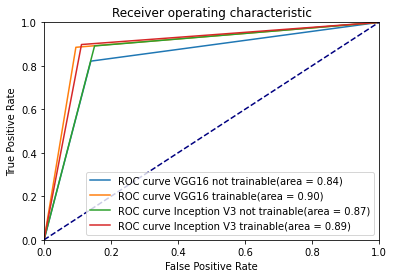

In [7]:
from sklearn import metrics
import seaborn as sn
import pandas as pd


test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')

test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]

test_images_labels = change_label(test_images_labels)


#test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))
test_images_tensor = toRGB(test_images_tensor)
#test_images_tensor = test_images_tensor.astype('float32') / 65535

predictions1 = (model1.predict(test_images_tensor) > 0.5).astype("int32")
predictions2 = (model2.predict(test_images_tensor) > 0.5).astype("int32")
predictions3 = (model3.predict(test_images_tensor) > 0.5).astype("int32")
predictions4 = (model4.predict(test_images_tensor) > 0.5).astype("int32")


fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,predictions1)
fpr2,tpr2,th2 = metrics.roc_curve(test_images_labels,predictions2)
fpr3,tpr3,th3 = metrics.roc_curve(test_images_labels,predictions3)
fpr4,tpr4,th4 = metrics.roc_curve(test_images_labels,predictions4)


roc_auc1 = metrics.roc_auc_score(test_images_labels,predictions1)
roc_auc2 = metrics.roc_auc_score(test_images_labels,predictions2)
roc_auc3 = metrics.roc_auc_score(test_images_labels,predictions3)
roc_auc4 = metrics.roc_auc_score(test_images_labels,predictions4)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve VGG16 not trainable(area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve VGG16 trainable(area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='ROC curve Inception V3 not trainable(area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='ROC curve Inception V3 trainable(area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



# Belign/Manignant

In [8]:
model1 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))
model2 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable_bm"))

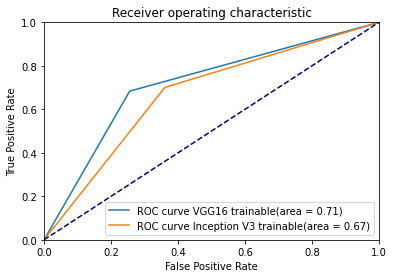

In [9]:
from sklearn import metrics
import seaborn as sn
import pandas as pd


test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')

test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]

test_images_labels = change_label_bm(test_images_labels)
test_images_tensor = toRGB(test_images_tensor)



predictions1 = (model1.predict(test_images_tensor) > 0.5).astype("int32")
predictions2 = (model2.predict(test_images_tensor) > 0.5).astype("int32")


fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,predictions1)
fpr2,tpr2,th2 = metrics.roc_curve(test_images_labels,predictions2)

roc_auc1 = metrics.roc_auc_score(test_images_labels,predictions1)
roc_auc2 = metrics.roc_auc_score(test_images_labels,predictions2)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve VGG16 trainable(area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve Inception V3 trainable(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# F2 metric for BM models
from sklearn.metrics import fbeta_score

print(fbeta_score(test_images_labels, predictions1, beta=2))
print(fbeta_score(test_images_labels, predictions2, beta=2))

0.6622516556291391
0.6518282988871223
